<a href="https://colab.research.google.com/github/spirosChv/imbizo2022/blob/main/exercises/exercise6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating dendrites - Part 6: The Perceptron Algorithm

In [1]:
# import packages
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

In [2]:
# @title Make nicer plots -- Execute this cell
def mystyle():
  """
  Create custom plotting style.

  Returns
  -------
  my_style : dict
      Dictionary with matplotlib parameters.

  """
  # color pallette
  style = {
      # Use LaTeX to write all text
      "text.usetex": False,
      "font.family": "DejaVu Sans",
      "font.weight": "bold",
      # Use 16pt font in plots, to match 16pt font in document
      "axes.labelsize": 16,
      "axes.titlesize": 20,
      "font.size": 16,
      # Make the legend/label fonts a little smaller
      "legend.fontsize": 14,
      "xtick.labelsize": 14,
      "ytick.labelsize": 14,
      "axes.linewidth": 2.5,
      "lines.markersize": 10.0,
      "lines.linewidth": 2.5,
      "xtick.major.width": 2.2,
      "ytick.major.width": 2.2,
      "axes.labelweight": "bold",
      "axes.spines.right": False,
      "axes.spines.top": False
  }

  return style


plt.style.use("seaborn-colorblind")
plt.rcParams.update(mystyle())

Before start building the Perceptron Model, first we need to load the required packages and the data set. The data set is present in the sklearn datasets module.

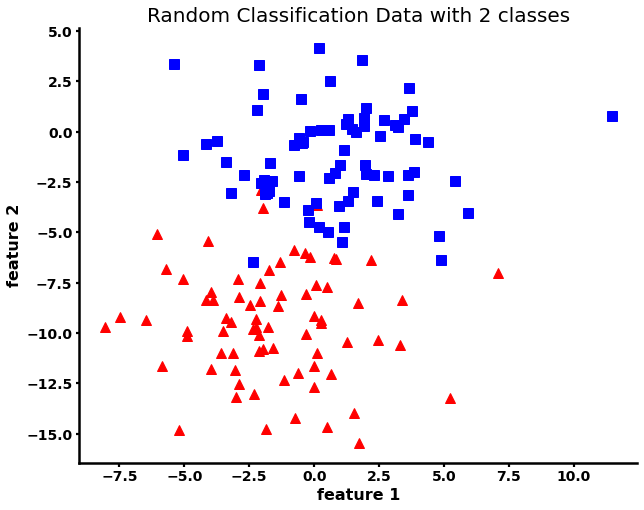

In [3]:
X, y = datasets.make_blobs(n_samples=150, n_features=2,
                           centers=2, cluster_std=2.55,
                           random_state=2)
# Plotting
fig = plt.figure(figsize=(10, 8))
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'r^')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.title('Random Classification Data with 2 classes')
plt.show()

There are two classes, red and green, and we want to separate them by drawing a straight line between them. Or, more formally, we want to learn a set of parameters theta to find an optimal hyperplane(straight line for our data) that separates the two classes.

Let’s code the step function.

In [4]:
def step_func(z):
  return 1.0 if (z > 0) else 0.0

We can visually understand the Perceptron by looking at the above image. For every training example, we first take the dot product of input features and parameters, theta. Then, we apply the Unit Step Function to make the prediction(`y_hat`).

And if the prediction is wrong or in other words the model has misclassified that example, we make the update for the parameters theta. We don’t update when the prediction is correct (or the same as the true/target value y).

Let’s see what the update rule is.

## Perceptron Update Rule

The perception update rule is very similar to the Gradient Descent update rule. The following is the update rule:

\begin{equation}
w_j := w_j + \eta \left( y^{[i]} - \phi(x^{[i]}) \right)x^{[i]}_j
\end{equation}

where $j \in [1, D]$, and $i \in [1, N]$, $D$: number of features, $N$: number of samples.

<br>

**Note:** Even though the Perceptron algorithm may look similar to logistic regression, it is actually a very different type of algorithm, since it is difficult to endow the perceptron’s predictions with meaningful probabilistic interpretations, or derive the perceptron as a maximum likelihood estimation algorithm.

In [5]:
def perceptron(X, y, lr, epochs):
  
  # X --> Inputs.
  # y --> labels/target.
  # lr --> learning rate.
  # epochs --> Number of iterations.
  
  # m-> number of training examples
  # n-> number of features 
  m, n = X.shape

  # Initializing parapeters (w) to zeros.
  # +1 in n+1 for the bias term.
  w = np.zeros((n+1, 1))

  # Empty list to store how many examples were 
  # misclassified at every iteration.
  n_miss_list = []

  # Training.
  for epoch in range(epochs):
    # variable to store misclassified.
    n_miss = 0
    # looping for every example.
    for idx, x_i in enumerate(X):
      # Insering 1 for bias, X0 = 1.
      x_i = np.insert(x_i, 0, 1).reshape(-1, 1)

      # Calculating prediction/hypothesis.
      y_hat = step_func(x_i.T @ w)

      # Updating if the example is misclassified.
      if (np.squeeze(y_hat) - y[idx]) != 0:
        w += lr*(y[idx] - y_hat)*x_i

        # Incrementing by 1.
        n_miss += 1

    # Appending number of misclassified examples
    # at every iteration.
    n_miss_list.append(n_miss)

  return w, n_miss_list

Let's initialize a new perceptron class object. Then we will use that object we will call `fit` method on our training data to learn the best possible parameters. We will evaluate the model performance on the test data by calculating the testing accuracy.

In [6]:
def plot_decision_boundary(X, w):
    
  # X --> Inputs
  # w --> parameters
  
  # The Line is y=mx+c
  # So, Equate mx+c = w0.X0 + w1.X1 + w2.X2
  # Solving we find m and c
  x1 = [min(X[:,0]), max(X[:,0])]
  m = -w[1]/w[2]
  c = -w[0]/w[2]
  x2 = m*x1 + c
  
  # Plotting
  fig = plt.figure(figsize=(10,8))
  plt.plot(X[:, 0][y==0], X[:, 1][y==0], "r^")
  plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
  plt.xlabel("feature 1")
  plt.ylabel("feature 2")
  plt.title('Perceptron Algorithm')
  plt.plot(x1, x2, 'y-')

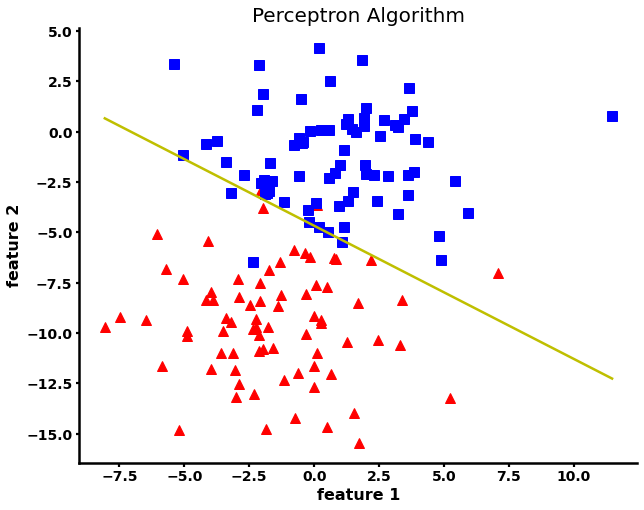

In [7]:
w, miss_l = perceptron(X, y, 0.5, 100)
plot_decision_boundary(X, w)

# Limitations of Perceptron Algorithm

- It is only a linear classifier, can never separate data that are not linearly separable.
- The algorithm is used only for Binary Classification problems.